In [35]:
BUILD_DIR="build"
INPUT_FILE="sample.mp4"

SAMPLER_FPS=0.25
SAMPLER_WIDTH=200
SAMPLER_HEIGHT=200

In [36]:
import cv2

from IPython.display import display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [37]:
def get_sample_inputs(input_file):
    cap = cv2.VideoCapture(input_file)
    fps=cap.get(cv2.CAP_PROP_FPS)
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    incrementer=fps/SAMPLER_FPS
    idx = incrementer
    sample_input_indexes = {}
    metadata = {
        'width': width,
        'height': height,
        'fps': fps
    }
    while idx < frame_count:
        idx_int = int(idx)
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx_int)
        ret, frame = cap.read()
        if not ret:
            break
        sample_input_indexes[idx] = frame
        idx = idx + incrementer
    cap.release()
    return sample_input_indexes, metadata

In [38]:
def np_array_to_image(img):
    imgrgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image=Image.fromarray(imgrgb)
    return image

In [39]:
def get_resized_image(np_img, width, height):
    resized_img = cv2.resize(np_img, (width, height), interpolation=cv2.INTER_LINEAR)
    return resized_img

In [40]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

In [41]:
sample_input_indexes, metadata = get_sample_inputs(INPUT_FILE)
sample_inputs_orig = list(sample_input_indexes.values())
sample_inputs = [ get_resized_image(img, SAMPLER_WIDTH, SAMPLER_HEIGHT) for img in sample_inputs_orig ];
results = model(list(sample_inputs))
resultImgs = [ result.plot() for result in results ]



0: 640x640 2 persons, 127.5ms
1: 640x640 3 persons, 127.5ms
2: 640x640 4 persons, 1 cell phone, 127.5ms
3: 640x640 4 persons, 127.5ms
4: 640x640 4 persons, 127.5ms
5: 640x640 1 person, 127.5ms
6: 640x640 2 persons, 127.5ms
7: 640x640 2 persons, 127.5ms
8: 640x640 2 persons, 127.5ms
9: 640x640 3 persons, 127.5ms
10: 640x640 5 persons, 127.5ms
11: 640x640 3 persons, 127.5ms
12: 640x640 3 persons, 127.5ms
13: 640x640 3 persons, 1 tie, 127.5ms
14: 640x640 3 persons, 127.5ms
15: 640x640 3 persons, 127.5ms
16: 640x640 4 persons, 1 tie, 127.5ms
17: 640x640 4 persons, 127.5ms
18: 640x640 3 persons, 1 tie, 127.5ms
19: 640x640 4 persons, 127.5ms
20: 640x640 4 persons, 1 tie, 127.5ms
21: 640x640 2 persons, 127.5ms
22: 640x640 4 persons, 1 cell phone, 127.5ms
23: 640x640 4 persons, 127.5ms
24: 640x640 4 persons, 127.5ms
25: 640x640 4 persons, 127.5ms
26: 640x640 4 persons, 127.5ms
27: 640x640 2 persons, 127.5ms
28: 640x640 3 persons, 127.5ms
29: 640x640 3 persons, 127.5ms
30: 640x640 5 persons, 1

In [42]:
def display_all_images(images, cols = 5):
    num_images = len(images)
    rows = int(np.ceil(num_images / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    cnt=0
    for ax, img in tqdm(zip(axes.flat, images), total=num_images, desc='Processing images to display'):
        display_image = np_array_to_image(img)
        ax.imshow(display_image)
        ax.axis('off')
        cnt = cnt + 1
    plt.tight_layout()
    plt.show()

In [ ]:
display_all_images(resultImgs)

In [43]:
from mtcnn import MTCNN
from deepface import DeepFace

In [44]:
'''
Algorithm with most information, but not best in face localization.
'''
def detect_faces_with_deepface(sample_image):
    face_analysis = DeepFace.analyze(sample_image, ['emotion', 'race'], enforce_detection=False)
    img_copy = sample_image.copy()
    for fa in face_analysis:
        emotions = fa['emotion']
        emotion = max(emotions, key=emotions.get)
        race = fa['dominant_race']
        region = fa['region']
        x, y, w, h = region['x'], region['y'], region['w'], region['h']
        img_copy = cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
        img_copy = cv2.putText(img_copy, emotion, (x, y - 2), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
    return img_copy

In [45]:
'''
Fast algorithm with cv2 with minimal information
'''
def detect_faces_with_haarcascade(sample_image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    img_copy = sample_image.copy()
    for face in faces:
        x, y, w, h = face
        img_copy = cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return img_copy

In [46]:
detector = MTCNN()
'''
Accurate algorithm with lesser performance
'''
def detect_faces_with_mtcnn(sample_image):
    faces = detector.detect_faces(sample_image)
    sample_image = sample_inputs_orig[test_index]
    img_copy = sample_image.copy()
    for face in faces:
        x, y, w, h = face['box']
        img_copy = cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return img_copy

In [ ]:
detections = []
for test_index in [ i * 20 for i in range(0, 10) ]: 
    sample_image = sample_inputs_orig[test_index]
    detections.append(sample_image)
    detections.append(detect_faces_with_deepface(sample_image))
    detections.append(detect_faces_with_haarcascade(sample_image))
    detections.append(detect_faces_with_mtcnn(sample_image))
display_all_images(detections, 4)

In [47]:
from scenedetect import detect, ContentDetector

In [48]:
input_file = INPUT_FILE
scene_list = detect(input_file, ContentDetector())

In [49]:
from dataclasses import dataclass, field

@dataclass
class AppScene:
    scene_orig: list = field(default=None)
    frame_start: int = field(default=None)
    frame_end: int = field(default=None)
    frames: list = field(default_factory=list)
    detects: list = field(default_factory=list)

In [161]:
number_of_frames_per_scene=3
cap = cv2.VideoCapture(input_file)
app_scenes = []
for scene in tqdm(scene_list, desc='Reading Frames from Scenes'):
    app_scene = AppScene()
    app_scene.scene_orig = scene
    scene_start_frame = scene[0].frame_num
    app_scene.frame_start = scene_start_frame
    scene_end_frame = scene[1].frame_num
    app_scene.frame_end = scene_end_frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, scene_start_frame)
    ret, frame = cap.read()
    app_scene.frames.append(frame)
    app_scenes.append(app_scene)


Reading Frames from Scenes:   0%|          | 0/361 [00:00<?, ?it/s]

In [194]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')
for scene in tqdm(app_scenes, desc('Detecting Objects from frames')):
    scene.detects = []
    scene.detects = model(scene.frames)

  0%|          | 0/361 [00:00<?, ?it/s]


0: 384x640 1 person, 55.6ms
Speed: 1.9ms preprocess, 55.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 book, 50.6ms
Speed: 1.2ms preprocess, 50.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 51.8ms
Speed: 0.9ms preprocess, 51.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 50.0ms
Speed: 1.1ms preprocess, 50.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 51.3ms
Speed: 0.9ms preprocess, 51.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 cell phone, 47.3ms
Speed: 0.9ms preprocess, 47.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 47.7ms
Speed: 0.9ms preprocess, 47.7ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1 cell phone, 49.3ms
Speed: 1.1ms preprocess, 49.3ms inference,

Processing images to display:   0%|          | 0/5 [00:00<?, ?it/s]

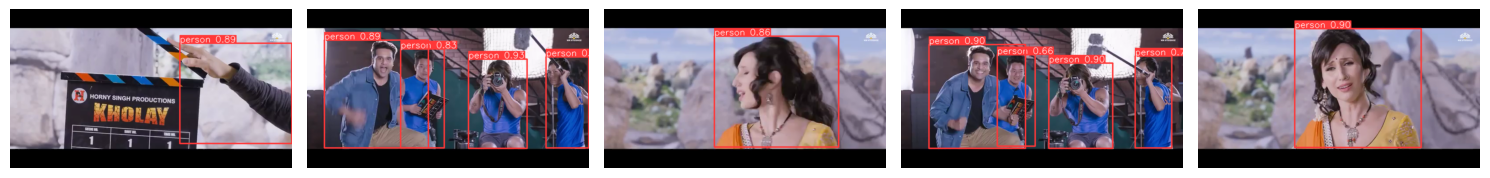

In [199]:
all_detects = sum([ scene.detects for scene in app_scenes ], [])
display_all_images([ d.plot() for d in all_detects ][:5])

In [200]:
def find_key(d, value):
    return next((k for k, v in d.items() if v == value), None)
yolo_person_class = find_key(model.names, 'person')
for detect in all_detects:
    detected_boxes = []
    for box in detect.boxes: 
        if int(box.cls[0]) == yolo_person_class:
            detected_boxes.append(box)
    detect.boxes = detected_boxes

Processing images to display:   0%|          | 0/5 [00:00<?, ?it/s]

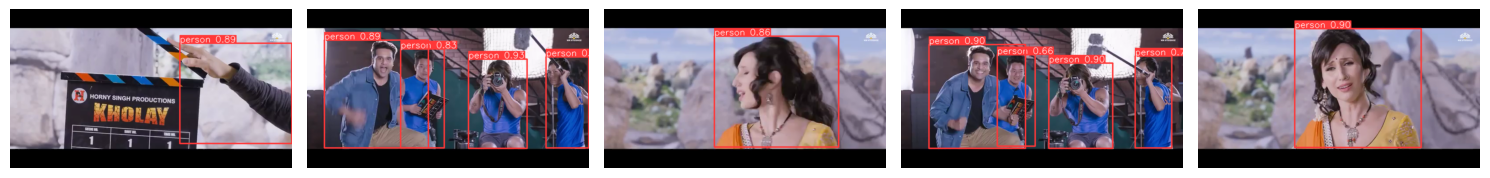

In [201]:
all_detects = sum([ scene.detects for scene in app_scenes ], [])
display_all_images([ d.plot() for d in all_detects ][:5])

In [202]:
detect_faces_with_mtcnn(sample_image)

NameError: name 'sample_image' is not defined